# Classification: Language Detection

Authors: Pierre Nugues and Marcus Klang

In this programming assignment, you will design and train a classifier to predict the language of a text. More concretely, you will reimplement Google's _Compact language detector_ (CLD3) from a high-level description. Read the description here: https://github.com/google/cld3

## Overview

Your classifier will read a short text, typically a few words or a sentence, and output the probability for all languages observed during training. The text will have a variable length and will be encoded as a Unicode string.

As dataset to train your models, you will use [Tatoeba](https://tatoeba.org/sv/), a collaborative, open, and free collection of sentences and translations.

You will break down the task into four steps:
    
  1. Data processing, converting the data into a machine-learnable representation
  2. Try and evaluate a simple model, logistic regression. This will be your baseline.
  3. Try and evaluate a deeper model inspired by Google's compact language detector, CLD3.
  4. CLD3 includes an embedding vectorization. This last part is left as an optional exercise.

### The Model: CLD3

CLD3 has three major characteristics:

   * It uses **$n$-grams** and splits an input text like _banana_ into three feature vectors that include:
       + Each unique character, unigrams ($n=1$)
       + Each unique pair of characters obtained from a sliding window of size 2, bigrams ($n=2$)
       + Each unique triple of characters obtained from a sliding window of size 3, trigrams ($n=3$)
       + These feature sets map to a set of indices (integer value).
   
   * It **hashes each symbol** i.e. it encrypts the $n$-gram into a fixed range integer.
       + This way of mapping features to indices is called feature hashing or the *hashing trick*
       + It reduces the number of symbols.
       + Constant memory requirements, depends on the hash function -- commonly only a few constants.
       + It is an approximate method as collisions can and will occur. Adjusting the size of the feature space i.e. the number of features to hash to, the collision probability can be reduced.
   
   * For each value of $n$, 1, 2, and 3, CLD3 computes the relative frequencies of the $n$-grams and **use them as weights**. See the figure below.
       + The model can map the input indices to embedding vectors (this part is optional)
       + It then computes the **weighted average** of the embeddings (this part is optional)
       + The model learns the embeddings during training (also optional)
       
The figure below shows the final architecture.

![Model overview](https://raw.githubusercontent.com/google/cld3/master/model.png)
Image source: https://github.com/google/cld3

## Dataset: Tatoeba

Your instructors have downsampled Tatoeba to reduce training times and guarantee that all the students have the same datasets.
* Link to datasets: https://github.com/pnugues/edan96/tree/main/classification%20lab
* Link to preprocessing notebook: https://github.com/pnugues/edan96/blob/main/programs/5-tatoeba_eda_select.ipynb

You are only required to process the small dataset. The larger one may take take and be difficult to process on small computers.

## Preliminaries

In [175]:
import random
import hashlib
from collections import Counter
from tqdm import tqdm

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

from sklearn.metrics import classification_report, confusion_matrix

Uncomment these lines the first time run the notebook to download the dataset

In [176]:
!wget https://github.com/pnugues/edan96/raw/main/classification%20lab/small_dataset.zip
!wget https://github.com/pnugues/edan96/raw/main/classification%20lab/large_dataset.zip
!unzip -o small_dataset.zip
!unzip -o large_dataset.zip

'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.


Archive:  small_dataset.zip
  inflating: __MACOSX/small_dataset/._train.tsv  
  inflating: small_dataset/test.tsv  
  inflating: small_dataset/val.tsv   


error:  cannot delete old small_dataset/train.tsv
        Permission denied


Archive:  large_dataset.zip
  inflating: large_dataset/train.tsv  
  inflating: __MACOSX/large_dataset/._train.tsv  
  inflating: large_dataset/test.tsv  
  inflating: large_dataset/val.tsv   


In [177]:
random.seed(4321)
torch.manual_seed(4321)

## Reading the Dataset

In [178]:
FILENAME_TRAIN = 'train.tsv'
FILENAME_VAL = 'val.tsv'
FILENAME_TEST = 'test.tsv'

In [179]:
SMALL_DATASET_PATH = 'small_dataset'
LARGE_DATASET_PATH = 'large_dataset'

## Settings
You have here the most significant settings

In [180]:
LARGE_DATASET = False # Use the small or large dataset
REL_FREQ = True # How we represent the n-grams in the input vector: with their relative frequency or with a 1

In [181]:
HIDDEN_LAYER = False  # Neural network with one hidden layer or logistic regression
HIDDEN_DIM = 512 # Number of hidden dimensions of the neural network
EPOCHS = 10 # Number of epochs
BATCH_SIZE = 32 # How many examples we will use for an update in the gradient descent

In [182]:
if LARGE_DATASET:
    dataset_path = LARGE_DATASET_PATH
else:
    dataset_path = SMALL_DATASET_PATH
    
FILE_TRAIN = dataset_path + '/' + FILENAME_TRAIN
FILE_VAL = dataset_path + '/' + FILENAME_VAL
FILE_TEST = dataset_path + '/' + FILENAME_TEST

We create a generator to read the datasets

In [183]:
def file_reader(file):
    with open(file, encoding='utf8', errors='ignore') as f:
        for line in f:
            row = line.strip()
            yield tuple(row.split('\t'))

In [184]:
line_generator = file_reader(FILE_TRAIN)

And we count the sentences per language

In [185]:
lang_freqs = Counter(map(lambda x: x[1], line_generator))

In [186]:
lang_freqs.most_common(15)

[('rus', 886),
 ('mkd', 876),
 ('eng', 873),
 ('lat', 854),
 ('swc', 847),
 ('tur', 844),
 ('tlh', 843),
 ('hun', 838),
 ('vie', 832),
 ('epo', 830),
 ('jpn', 830),
 ('nld', 826),
 ('lfn', 824),
 ('deu', 821),
 ('ces', 814)]

In [187]:
langs = sorted(list(set(lang_freqs.keys())))
langs[:10]

['ara', 'ber', 'bul', 'ces', 'cmn', 'dan', 'deu', 'ell', 'eng', 'epo']

You will create an index of the languages of your dataset: Assign a number to each language. You will call it `idx2lang` and its type will be a dictionary.

In [188]:
# Write your code
idx2lang = {idx: string for idx, string in enumerate(langs)} # Index to language using list comprehension

In [189]:
idx2lang

{0: 'ara',
 1: 'ber',
 2: 'bul',
 3: 'ces',
 4: 'cmn',
 5: 'dan',
 6: 'deu',
 7: 'ell',
 8: 'eng',
 9: 'epo',
 10: 'fin',
 11: 'fra',
 12: 'hau',
 13: 'heb',
 14: 'hun',
 15: 'ina',
 16: 'ita',
 17: 'jpn',
 18: 'kab',
 19: 'lat',
 20: 'lfn',
 21: 'lit',
 22: 'mar',
 23: 'mkd',
 24: 'nld',
 25: 'pes',
 26: 'pol',
 27: 'por',
 28: 'ron',
 29: 'rus',
 30: 'spa',
 31: 'srp',
 32: 'swc',
 33: 'swe',
 34: 'tlh',
 35: 'tok',
 36: 'tur',
 37: 'ukr',
 38: 'vie'}

Write the reverted `lang2idx` index to convert languages to indices. It is also a dictionary

In [190]:
# Write your code
lang2idx = {string: idx for idx, string in enumerate(langs)} # Language to index using list comprehension

In [191]:
lang2idx

{'ara': 0,
 'ber': 1,
 'bul': 2,
 'ces': 3,
 'cmn': 4,
 'dan': 5,
 'deu': 6,
 'ell': 7,
 'eng': 8,
 'epo': 9,
 'fin': 10,
 'fra': 11,
 'hau': 12,
 'heb': 13,
 'hun': 14,
 'ina': 15,
 'ita': 16,
 'jpn': 17,
 'kab': 18,
 'lat': 19,
 'lfn': 20,
 'lit': 21,
 'mar': 22,
 'mkd': 23,
 'nld': 24,
 'pes': 25,
 'pol': 26,
 'por': 27,
 'ron': 28,
 'rus': 29,
 'spa': 30,
 'srp': 31,
 'swc': 32,
 'swe': 33,
 'tlh': 34,
 'tok': 35,
 'tur': 36,
 'ukr': 37,
 'vie': 38}

## Data processing — convert the sentences into feature vectors

For the context of this program, a feature is a string of 1 to 3 characters. 
In natural language processing, they are called $n$-grams as they can have a varying size and are created from a sliding window.

Common sizes of $n$ have names unigrams ($n$=1), bigrams ($n$=2), and trigrams ($n$=3))

To serve as input, we have to convert these $n$-grams to numbers. There are two common ways to encode features into indices:
 * Mapping each symbol to an index
    + Exact and precise
    + Can have high memory requirements with vast feature spaces as each known feature must be stored and be assigned a unique index.
    + Slow, you need to precompute your feature space, convert the incoming data to an index and retain the mapping in memory at all times.
 * Hashing trick: hash the feature into a index
    + Supports an arbitrary number of features with the caveat of collisions.
    + Constant memory requirements
    + Fast, any feature even an unknown one can be converted into a feature index
    + However, if the feature space is too small, features will have many collisions. You have then to choose a good hash function and a feature space that is big enough
    
We will use the [hashing trick](https://en.wikipedia.org/wiki/Feature_hashing). In Python, `hash` is a function that converts any supported object into a number (hash code) but it is not reproducible across the sessions - it changes each time the interpreter is started.
We have therefore provided a new function `reproducible_hash` that hashes a string but in a reproducible way.

The number returned by `reproducible_hash` is big and needs to be converted into a limited space. This can be done with the use of the remainder of an integer division, the [modulo](https://en.wikipedia.org/wiki/Modulo_operation).

### Extracting $n$-grams

Create an $n$-gram function that returns the $n$-grams of a string. The $n$ value will be passed as an argument. You will optionally set the string in lower case (`lc` argument).

In [192]:
# Write your code here
def ngrams(sentence, n=1, lc=True):
    ngram_l = []
    if lc:
        sentence = sentence.lower()
    # split sentence into words
    words = sentence.split()
    # let's take the "banana" example
        # if n = 1, we will have ['b', 'a', 'n', 'a', 'n', 'a'], that is, 6 unigrams
        # if n = 2, we will have ['ba', 'an', 'na', 'an', 'na'], that is, 5 bigrams
        # if n = 3, we will have ['ban', 'ana', 'nan', 'ana'], that is, 4 trigrams
        # which means that the loop should go from 0 to len(words) - n + 1
    for word in words:
        for i in range(len(word) - n + 1):
            ngram_l.append(word[i:i + n])
    return ngram_l


In [193]:
def all_ngrams(sentence, max_ngram=3, lc=True):
    all_ngram_list = []
    for i in range(1, max_ngram + 1):
        all_ngram_list += [ngrams(sentence, n=i, lc=lc)]
    return all_ngram_list

In [194]:
all_ngrams('banana')

[['b', 'a', 'n', 'a', 'n', 'a'],
 ['ba', 'an', 'na', 'an', 'na'],
 ['ban', 'ana', 'nan', 'ana']]

### Limiting the $n$-grams numbers

We set the modulos

In [195]:
if LARGE_DATASET:
    MAX_CHARS = 2053
    MAX_BIGRAMS = 4099
    MAX_TRIGRAMS = 4099  #8192
else:
    MAX_CHARS = 521
    MAX_BIGRAMS = 1031
    MAX_TRIGRAMS = 1031 

In [196]:
NUM_FEATURES = MAX_CHARS + MAX_BIGRAMS + MAX_TRIGRAMS
NUM_FEATURES
# number of features is still 3 actually,
# by NUM_FEATURES we mean the number of possible feature values

2583

### Hash Codes

In [197]:
def reproducible_hash(string):
    """
    reproducible hash on any string
    
    Arguments:
       string: python string object
    
    Returns:
       signed int64
    """
    
    # We are using MD5 for speed not security.
    # usedforsecurity=False is apparently not supported in python 3.8 
    h = hashlib.md5(string.encode("utf-8"))
    return int.from_bytes(h.digest()[0:8], 'big', signed=True)

In [198]:
[reproducible_hash(x) % MAX_TRIGRAMS for x in all_ngrams('banana')[2]]
# Here we compute the hash value for each of the trigrams (all_ngrams('banana')[2]) in the word 'banana'
# And then do the modulo operation on them to get the index of the trigram in the feature vector

[487, 876, 246, 876]

In [199]:
MAXES = [MAX_CHARS, MAX_BIGRAMS, MAX_TRIGRAMS]

Create a `hash_ngrams` function that creates a list of hash codes from a list of $n$-grams. As arguments, you will have the list of $n$-grams as well as the list of dividers (`MAXES`). See the example below

In [200]:
# Write your code
def hash_ngrams(ngrams, modulos):
    hash_codes = []
    for modIndex, ngram in enumerate(ngrams):
        hash_codes.append([reproducible_hash(x) % modulos[modIndex] for x in ngram])
    return hash_codes

In [201]:
hash_banana = hash_ngrams(all_ngrams('banana'), MAXES)
hash_banana

[[25, 234, 310, 234, 310, 234],
 [994, 649, 808, 649, 808],
 [487, 876, 246, 876]]

### Hash codes relative frequencies
CLD3 associates the $n$-gram hash codes with their relative frequencies in the text. See the example in Google CLD3 page.

Create a `rel_freqs` function that computes the frequencies from lists of hash codes. The input will be a list of three lists of hash codes, for the unigrams, bigrams, and trigrams. The output will be a list of a three dictionaries, where the keys will be the $n$-gram hash codes and the values, the relative frequency. See example. 

In [202]:
# Write your code
def rel_freqs(lst):
    output_list = []
    for ngram_l in lst:
        ngram_freq_dict = {}
        ngram_freq = Counter(ngram_l)
        total = sum(ngram_freq.values())
        for key, value in ngram_freq.items():
            ngram_freq_dict[key] = value / total
        output_list.append(ngram_freq_dict)
    return output_list


In [203]:
# freqs_banana = [rel_freqs(x) for x in hash_banana] this does not work or match the description in the assignment
freqs_banana = rel_freqs(hash_banana) # this is more like it, since the input was supposed to be a list of three lists of hash codes.
freqs_banana

[{25: 0.16666666666666666, 234: 0.5, 310: 0.3333333333333333},
 {994: 0.2, 649: 0.4, 808: 0.4},
 {487: 0.25, 876: 0.5, 246: 0.25}]

## Multihot vectors

Write a `multihot` function that creates a torch vector of 0.0 and 1.0 from a dictionary of indices and frequencies. You will pass the size of the vector as an argument. All the indices in the dictionary will be set to 1.0 and the rest will be set to 0.0

In [204]:
# Write your code here
def multihot(idx_freq, max):
    feat_vector = torch.zeros(max)
    for idx, freq in idx_freq.items():
        feat_vector[idx] = 1.0
    return feat_vector

In [205]:
mhot_char_banana = multihot(freqs_banana[0], MAX_CHARS)
mhot_char_banana

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 

In [206]:
torch.nonzero(mhot_char_banana)

tensor([[ 25],
        [234],
        [310]])

In [207]:
mhot_bigram_banana = multihot(freqs_banana[1], MAX_BIGRAMS)
mhot_bigram_banana

tensor([0., 0., 0.,  ..., 0., 0., 0.])

In [208]:
torch.nonzero(mhot_bigram_banana)

tensor([[649],
        [808],
        [994]])

In [209]:
mhot_trigram_banana = multihot(freqs_banana[2], MAX_TRIGRAMS)
mhot_trigram_banana

tensor([0., 0., 0.,  ..., 0., 0., 0.])

In [210]:
torch.nonzero(mhot_trigram_banana)

tensor([[246],
        [487],
        [876]])

## Replacing Booleans with frequencies

Write a `multihot_freq` function that creates a torch vector of frequencies from a dictionary of indices and frequencies. You will pass the size of the vector as an argument. All the indices in the dictionary will be set to the dictionary values (the relative frequencies) and the rest will be set to 0.0

In [211]:
# Write your code
def multihot_freq(idx_freq, max):
    feat_vector = torch.zeros(max)
    for idx, freq in idx_freq.items():
        feat_vector[idx] = freq
    return feat_vector

In [212]:
freq_char_banana = multihot_freq(freqs_banana[0], MAX_CHARS)
freq_char_banana

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1667, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 

In [213]:
torch.nonzero(freq_char_banana).T

tensor([[ 25, 234, 310]])

In [214]:
freq_char_banana[torch.nonzero(freq_char_banana)].T

tensor([[0.1667, 0.5000, 0.3333]])

## Creating $X$ and $\mathbf{y}$ tensors

We create a function to read the files and return the language and the sentence. We create the $X$ and $\mathbf{y}$ tensors from them.

In [215]:
def read_sent_lang(file):
    with open(file, encoding='utf8', errors='ignore') as f:
        for line in f:
            row = line.strip()
            lang_tuple = tuple(row.split('\t'))
            yield lang_tuple[2], lang_tuple[1]   

The code below creates a $X$ and $\mathbf{y}$ tensors. Note that $X$ is a matrix and $\mathbf{y}$, a vector.

In [216]:
def create_Xy(file, multihot_func, lang2idx):
    X_l = []
    y_symb = []
    line_cnt = 0
    for sentence, lang in read_sent_lang(file):
        line_cnt += 1
    X = torch.empty((line_cnt, NUM_FEATURES))
    for i, (sentence, lang) in tqdm(enumerate(read_sent_lang(file))):
        hashes = hash_ngrams(all_ngrams(sentence), MAXES)
        # Once again I will change here to fit the description in the assignment
        hash_freq_l = rel_freqs(hashes)
        #hash_freq_l = map(rel_freqs, hashes)
        x_row_l = []
        for hash_freq_dict, max in zip(hash_freq_l, MAXES):
            x_row_l += [multihot_func(hash_freq_dict, max)]
        X[i, :] = torch.cat(x_row_l, -1)
        y_symb += [lang]
    y = torch.LongTensor(list(map(lang2idx.get, y_symb)))
    return X, y


In [217]:
if REL_FREQ:
    X_train, y_train =  create_Xy(FILE_TRAIN, multihot_freq, lang2idx)
    X_val, y_val =  create_Xy(FILE_VAL, multihot_freq, lang2idx)
    X_test, y_test =  create_Xy(FILE_TEST, multihot_freq, lang2idx)
else:
    X_train, y_train =  create_Xy(FILE_TRAIN, multihot, lang2idx)
    X_val, y_val =  create_Xy(FILE_VAL, multihot, lang2idx)
    X_test, y_test =  create_Xy(FILE_TEST, multihot, lang2idx)

# The function create_Xy creates two outputs:
# X: a 2D (matrix) tensor with the shape (number of sentences, number of features)
# each row represents a multihot feature vector for a sentence
# y: a 1D tensor with the shape (number of sentences), containing the labels for each sentence,
# where the labels are the indices of the languages in the list of languages

31376it [00:13, 2320.37it/s]
3922it [00:01, 2355.48it/s]
3923it [00:01, 2322.39it/s]


In [218]:
X_train.size()

torch.Size([31376, 2583])

In [219]:
y_train[:10]

tensor([37, 28, 25, 21, 15, 24,  9, 38, 21, 16])

## Building a Classifier

We create the classifier

In [220]:
input_dim = X_train.size()[1]
print(input_dim) # this is the number of features

2583


Write two model architectures using `nn.Sequential`. One corresponding to logistic regression and the other with one hidden layer.

In [221]:
# Write your code here
if HIDDEN_LAYER:
    model = nn.Sequential(
        nn.Linear(input_dim, HIDDEN_DIM),
        nn.ReLU(),
        nn.Linear(HIDDEN_DIM, len(langs))
        )
else:
    model = nn.Sequential(
        nn.Linear(input_dim, len(langs))
        )

In [222]:
model

Sequential(
  (0): Linear(in_features=2583, out_features=39, bias=True)
)

We set the loss and the optimizer

In [223]:
loss_fn = nn.CrossEntropyLoss()    # cross entropy loss measures the performance of a classification model. Namely, it measures the difference between 
                                    # two probability distributions: the true distribution and the predicted distribution.
optimizer = torch.optim.NAdam(model.parameters(), lr=0.01)

## Loading the dataset
We use a data loader to supply the training loop with batches

In [224]:
# TensorDataset combines tensors into a dataset
# Each sample in the dataset is a pair: (X_train[i], y_train[i])
# Useful for supervised learning tasks where inputs and labels are paired
dataset = TensorDataset(X_train, y_train)

# DataLoader provides an easy way to iterate through the dataset in mini-batches during training
# Handles batching, shuffling, and parallel loading efficiently
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

## Training the classifier
We have a classifier. We now train it on the dataset

Write the training loop

In [237]:
loss_train_history = []
acc_train_history = []
loss_val_history = []
acc_val_history = []
for epoch in tqdm(range(EPOCHS)):
    model.train() # set the model to training mode
    loss_train = 0
    for X_batch, y_batch in dataloader:
        y_pred = model(X_batch) # forward pass, i.e: compute the predicted y. We want to predict the language of the sentence. So the output is the probability of each language
        loss_train = loss_fn(y_pred, y_batch) # compute the loss. The loss is the difference between the predicted y and the true y (probability distributions)
        optimizer.zero_grad() # zero the gradients. Why? Because the gradients are accumulated in PyTorch. If we don't zero them, they will accumulate across batches
        loss_train.backward() # backpropagation. Compute the gradients of the loss with respect to the model parameters. In order to update the model parameters.
        optimizer.step() # update the model parameters. The optimizer adjusts the model parameters to minimize the loss
        loss_train += loss_train.item() # add the loss to the total loss

    loss_train_history += [BATCH_SIZE * loss_train / len(y_train)]

    y_val_pred = model(X_val) # predict the validation set
    y_val_pred = torch.argmax(y_val_pred, dim=1) # get the index of the maximum value in the predicted y. This is the predicted language for each sentence
    acc_val_history.append(sum(y_val_pred == y_val) / len(y_val)) # compute the accuracy of the validation set. The accuracy is the number of correct predictions divided by the total number of predictions


 10%|█         | 1/10 [00:01<00:15,  1.78s/it]

tensor([13, 15, 31,  ..., 20, 21, 17])


 20%|██        | 2/10 [00:03<00:12,  1.60s/it]

tensor([13, 15, 31,  ..., 20, 21, 17])


 30%|███       | 3/10 [00:04<00:10,  1.57s/it]

tensor([13, 15, 31,  ..., 20, 21, 17])


 30%|███       | 3/10 [00:05<00:13,  1.87s/it]


KeyboardInterrupt: 

We plot the loss

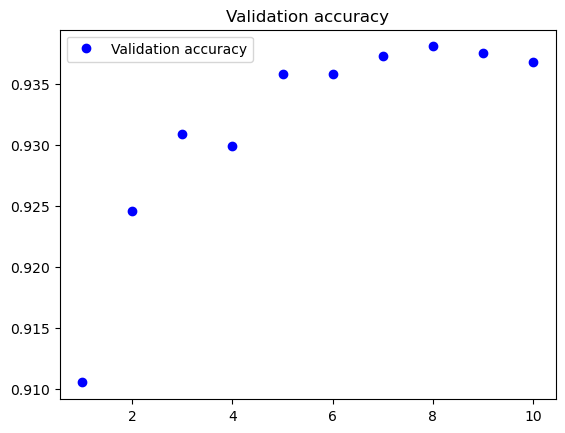

In [226]:
import matplotlib.pyplot as plt

epochs = range(1, len(acc_val_history) + 1)
plt.plot(epochs, acc_val_history, 'bo', label='Validation accuracy')
plt.title('Validation accuracy')
plt.legend()
plt.show()

## Predicting the test set
Predict the whole test set. Call the resulting vector `y_test_pred`.

In [227]:
# Write your code
y_test_pred = torch.argmax(model(X_test), dim=1)

In [228]:
y_test_pred[:10]

tensor([32,  1, 18, 37, 19, 35, 32, 23, 12, 16])

In [229]:
print(classification_report(y_test, y_test_pred, target_names=langs, digits=4))

              precision    recall  f1-score   support

         ara     0.9888    1.0000    0.9944        88
         ber     0.6804    0.6735    0.6769        98
         bul     0.8776    0.8600    0.8687       100
         ces     0.9773    0.9451    0.9609        91
         cmn     0.9905    1.0000    0.9952       104
         dan     0.8957    0.9279    0.9115       111
         deu     0.9780    0.9889    0.9834        90
         ell     1.0000    1.0000    1.0000       106
         eng     0.9688    0.9588    0.9637        97
         epo     0.9457    1.0000    0.9721        87
         fin     0.9905    0.9541    0.9720       109
         fra     0.9674    0.9674    0.9674        92
         hau     0.9694    0.9896    0.9794        96
         heb     1.0000    1.0000    1.0000        99
         hun     1.0000    0.9798    0.9898        99
         ina     0.8850    0.9524    0.9174       105
         ita     0.9333    0.9333    0.9333       105
         jpn     1.0000    

In [230]:
print(confusion_matrix(y_test, y_test_pred))

[[ 88   0   0 ...   0   0   0]
 [  0  66   0 ...   0   0   0]
 [  0   0  86 ...   0   0   0]
 ...
 [  0   0   0 ...  85   0   0]
 [  0   0   1 ...   0 112   0]
 [  0   0   0 ...   0   0  91]]


## Applying the Detector

In [238]:
def encode(text, multihot_func, MAXES):
    hashes = hash_ngrams(all_ngrams(text), MAXES)
    hash_freq_l = rel_freqs(hashes)
    x_row = torch.empty((0,))
    for hash_freq_dict, max in zip(hash_freq_l, MAXES):
        x_row = torch.hstack((x_row, multihot_func(hash_freq_dict, max)))
    return x_row

In [232]:
test_sents = ['Hi guys and girls!',
'Hur mår du nu?', 
'Allt bra idag?', 
'Salut tout le monde !']

In [233]:
for sent in test_sents:
    if REL_FREQ:
        row = encode(sent, multihot_freq, MAXES)
    else:
        row = encode(sent, multihot, MAXES)
    print(sent, idx2lang[torch.argmax(model(row), dim=-1).item()])

Hi guys and girls! eng
Hur mår du nu? swe
Allt bra idag? swe
Salut tout le monde ! fra


## Checking Values
Your instructor used this piece of code to test his program

line 30316 of training set: _Stanna!_

The extracted values should match the vector

In [234]:
list(rel_freqs(hash_ngrams(all_ngrams('Stanna!'), MAXES)))

[{331: 0.14285714285714285,
  432: 0.14285714285714285,
  234: 0.2857142857142857,
  310: 0.2857142857142857,
  333: 0.14285714285714285},
 {12: 0.16666666666666666,
  603: 0.16666666666666666,
  649: 0.16666666666666666,
  870: 0.16666666666666666,
  808: 0.16666666666666666,
  547: 0.16666666666666666},
 {451: 0.2, 166: 0.2, 697: 0.2, 821: 0.2, 1017: 0.2}]

In [235]:
torch.nonzero(X_train[30316]).T

tensor([[ 234,  310,  331,  333,  432,  533, 1068, 1124, 1170, 1329, 1391, 1718,
         2003, 2249, 2373, 2569]])

In [236]:
X_train[30316, torch.nonzero(X_train[30316])].T

tensor([[0.2857, 0.2857, 0.1429, 0.1429, 0.1429, 0.1667, 0.1667, 0.1667, 0.1667,
         0.1667, 0.1667, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000]])

## Results

You will report your results for the different methods you tried. You are only required to process the small dataset.


| Method   |      Corpus      |  Encoding | Macro F1: Val. set| Macro F1: Test set|
|----------|:-------------|:------|------:|------:|
| Logistic regression |  Small | Booleans |xx|0.9277      |
| Logistic regression |    Large   |   Booleans |xx|xx|
| Logistic regression |  Small |    Frequencies |0.9365|0.9471|
| Logistic regression |  Large |    Frequencies |xx|xx|
| Neural network |  Small | Booleans |xx  |0.9087|
| Neural network |    Large   |   Booleans |xx|xx|
| Neural network |  Small |    Frequencies |xx|0.9199|
| Neural network |  Large |    Frequencies |xx|xx|
    